# List of seaborn dataset

https://github.com/mwaskom/seaborn-data

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedKFold, GroupShuffleSplit, GroupKFold

# 表示用の設定を変更します
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 130

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [75]:
import matplotlib

# RC params リセット
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# Set rcParams
params = {"font.family":"IPAexGothic","font.size":10, "figure.figsize":[3,3], "axes.labelsize":11, 
          "xtick.labelsize":10, "ytick.labelsize":10}

# Get nice grid line from seaborn while updating rc params
sns.set_theme(rc=params)
sns.set(font_scale=1.2)
plt.rcParams["font.family"] = "IPAexGothic"


# Binary Clasiffication

## Logistic Regression

In [142]:
peng = sns.load_dataset("penguins")

peng.dropna(inplace=True)

total = peng.isnull().sum().sort_values(ascending=False)
percent = (peng.isnull().sum()/peng.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

print(missing_data.head(3))

                Total  Percent
species             0      0.0
island              0      0.0
bill_length_mm      0      0.0


In [143]:

# One hot
peng = pd.get_dummies(peng, columns=["species", "island"], drop_first=True, dummy_na=True)


#Label encoding
from sklearn.preprocessing import LabelEncoder 

label_encoder = LabelEncoder()

cols = ["sex"]

for col in cols:
    peng.loc[:, col] = label_encoder.fit_transform(peng.loc[:, col])


train, test = peng[100:], peng[:100]

train.columns.values
test.columns.values

array(['species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex'], dtype=object)

array(['species', 'island', 'bill_length_mm', 'bill_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex'], dtype=object)

In [144]:
from sklearn.linear_model import LogisticRegression

train_y = train["sex"]
train_X = train.drop(["sex"], axis=1)

test_y = test["sex"]
test_X = test.drop(["sex"], axis=1)

In [5]:
clf = LogisticRegression(random_state=0).fit(train_X, train_y)

preds = clf.predict(test_X)

print("accuracy:  ", accuracy_score(preds, test_y))
print("f1 score:  ", f1_score(preds,test_y))
print("precision: ", precision_score(preds,test_y))
print("recall:    ", recall_score(preds,test_y))

accuracy:   0.84
f1 score:   0.8620689655172413
precision:  1.0
recall:     0.7575757575757576


## Random Forest

In [146]:
peng = sns.load_dataset("penguins")

peng.dropna(inplace=True)

#Label encoding
from sklearn.preprocessing import LabelEncoder 

label_encoder = LabelEncoder()

cols = ["sex","species", "island"]

for col in cols:
    peng.loc[:, col] = label_encoder.fit_transform(peng.loc[:, col])

peng_y = peng["sex"]
peng_X = peng.drop("sex", axis=1)

from sklearn.model_selection import train_test_split
train_X, valid_X, train_y, valid_y = train_test_split(peng_X, peng_y, test_size=0.2, random_state=0, stratify=peng_y)


RandomForestClassifier(max_depth=2, random_state=0)

accuracy:   0.8507462686567164
f1 score:   0.8571428571428571
precision:  0.8823529411764706
recall:     0.8333333333333334


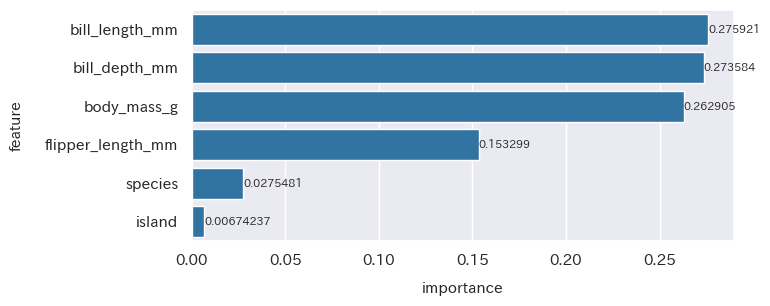

In [148]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(train_X, train_y)

preds = clf.predict(valid_X)

print("accuracy:  ", accuracy_score(preds, valid_y))
print("f1 score:  ", f1_score(preds,valid_y))
print("precision: ", precision_score(preds,valid_y))
print("recall:    ", recall_score(preds,valid_y))


fe_imp = pd.DataFrame(zip(train_X.columns.values,clf.feature_importances_), columns=["feature", "importance"])
fe_imp = fe_imp.sort_values(by="importance", ascending=False)

_ = plt.figure(figsize=(7,3))

# Set hue for grouped bar plot

p = sns.barplot(x="importance", y="feature", data=fe_imp, color='#1f77b4')

_ = plt.ylabel("feature", rotation='vertical', labelpad=15, fontsize=11)
_ = plt.xlabel("importance", labelpad=10, fontsize=11)
_ = plt.tick_params(axis='both', which='major', labelsize=11)


_ = plt.bar_label(p.containers[0], size=8)


## LightGBM

Doc: https://lightgbm.readthedocs.io/en/latest/

### Training API

Doc: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.train.html
Parameters: https://lightgbm.readthedocs.io/en/latest/Parameters.html

Parameter explanaitions:

verbose_eval (bool or int, optional (default=True)) –
Requires at least one validation data. If True, the eval metric on the valid set is printed at each boosting stage. If int, the eval metric on the valid set is printed at every verbose_eval boosting stage.


min_child_samples (int, optional (default=20)) – Minimum number of data needed in a child (leaf).



In [97]:
peng = sns.load_dataset("penguins")

peng.dropna(inplace=True)

#Label encoding
from sklearn.preprocessing import LabelEncoder 

label_encoder = LabelEncoder()

cols = ["sex","species", "island"]

for col in cols:
    peng.loc[:, col] = label_encoder.fit_transform(peng.loc[:, col])

peng_y = peng["sex"]
peng_X = peng.drop("sex", axis=1)

from sklearn.model_selection import train_test_split
train_X, valid_X, train_y, valid_y = train_test_split(peng_X, peng_y, test_size=0.2, random_state=0, stratify=peng_y)


#### without fold

In [15]:
import lightgbm as lgb

params = {
		  'objective': 'binary',
		  'num_leaves': 10,
		  'min_child_samples': 5,
		  # 'objective': 'binary',
# 		  'max_depth': -1,
		  'learning_rate': 0.01,
# 		  "boosting_type": "gbdt",
		  # "subsample_freq": 3,
		  # "subsample": 0.9,
		  # "bagging_seed": 0,
		  "metric": 'binary_logloss',
		  # "verbosity": -1,
		  # 'reg_alpha': 0.3,
		  # 'reg_lambda': 0.3,
		  # 'colsample_bytree': 0.9,
		  #'categorical_feature': categories
		 }


lgb_train = lgb.Dataset(train_X, train_y)
lgb_eval = lgb.Dataset(valid_X, valid_y, reference=lgb_train)


model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=1,
    num_boost_round=1,
    early_stopping_rounds=10
)

preds = model.predict(valid_X, num_iteration=model.best_iteration)

preds = (preds > 0.5).astype(int)

print("accuracy:  ", accuracy_score(preds, valid_y))
print("f1 score:  ", f1_score(preds,valid_y))
print("precision: ", precision_score(preds,valid_y))
print("recall:    ", recall_score(preds,valid_y))

[LightGBM] [Info] Number of positive: 134, number of negative: 132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 266, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503759 -> initscore=0.015038
[LightGBM] [Info] Start training from score 0.015038
[1]	training's binary_logloss: 0.686083	valid_1's binary_logloss: 0.686191
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1]	training's binary_logloss: 0.686083	valid_1's binary_logloss: 0.686191
accuracy:   0.8955223880597015
f1 score:   0.9014084507042254
precision:  0.9411764705882353
recall:     0.8648648648648649


#### Feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

Text(0.5, 1.0, 'Feature importance (importance type=gain)')

Text(0, 0.5, 'Features')

Text(0.5, 0, 'Feature importance')

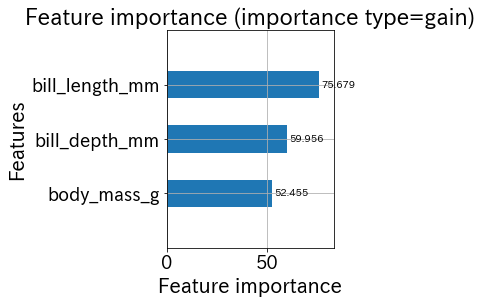

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(3,4))

lgb.plot_importance(model, max_num_features=30, height=0.5, importance_type="gain", ax=ax)

plt.title("Feature importance (importance type=gain)", size=22)
plt.ylabel("Features", size=20)
plt.xlabel("Feature importance", size=20)

plt.tick_params(axis='both', which='major', labelsize=18)


#### SHAP values

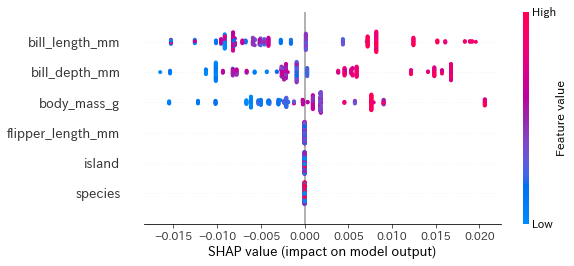

In [22]:
import shap
shap.initjs()

use_cols = list(train_X.columns.values)

# train_X[use_cols].columns

explainer = shap.TreeExplainer(model, data=train_X[use_cols], feature_dependence="tree_path_dependent")

X_tr_values = explainer.shap_values(train_X[use_cols])


shap.summary_plot(shap_values=X_tr_values,
                  features=train_X[use_cols],
                  feature_names=train_X[use_cols].columns)


#### Tree split

Text(0.5, 1.0, 'Booster index: 0')

<AxesSubplot:title={'center':'Booster index: 0'}>

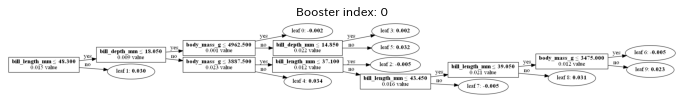

'Tree.gv.png'

In [26]:
# 先頭の決定木を可視化してみる
# rows should be 2 for tree index = 0, and 1
rows = 1
cols = 1
# 表示する領域を準備する
fig = plt.figure(figsize=(12, 6))
# 一本ずつプロットしていく
for i in range(rows * cols):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(f'Booster index: {i}')
    lgb.plot_tree(booster=model,
                    tree_index=i,
                    show_info='internal_value',
                    ax=ax,
                    orientation="horizontal"
                    )
    
# fig.set_size_inches(50, 50)

plt.show()

graph = lgb.create_tree_digraph(model, tree_index=0, format='png', name='Tree', show_info="split_gain")
graph.render(view=True)



#### With fold

In [73]:
import lightgbm as lgb

params = {
		  'objective': 'binary',
		  'num_leaves': 10,
		  'min_child_samples': 5,
		  # 'objective': 'binary',
# 		  'max_depth': -1,
		  'learning_rate': 0.01,
# 		  "boosting_type": "gbdt",
		  # "subsample_freq": 3,
		  # "subsample": 0.9,
		  # "bagging_seed": 0,
		  "metric": 'binary_logloss',
		  # "verbosity": -1,
		  # 'reg_alpha': 0.3,
		  # 'reg_lambda': 0.3,
		  # 'colsample_bytree': 0.9,
		  #'categorical_feature': categories
		 }


# from sklearn.model_selection import train_test_split
# train_X, valid_X, train_y, valid_y = train_test_split(peng_X, peng_y, test_size=0.2, random_state=0, stratify=peng_y)

lgb_train = lgb.Dataset(peng_X, peng_y)
# lgb_eval = lgb.Dataset(valid_X, valid_y, reference=lgb_train)


model = lgb.cv(
    params, lgb_train,
    nfold=2,
    stratified=False,
#     valid_sets=[lgb_train, lgb_eval],
#     verbose_eval=1,
    num_boost_round=1,
#     early_stopping_rounds=10
)


[LightGBM] [Info] Number of positive: 94, number of negative: 72
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261
[LightGBM] [Info] Number of data points in the train set: 166, number of used features: 6
[LightGBM] [Info] Number of positive: 74, number of negative: 92
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 261
[LightGBM] [Info] Number of data points in the train set: 166, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.566265 -> initscore=0.266629
[LightGBM] [Info] Start training from score 0.266629
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.445783 -> initscore=-0.217723
[LightGBM] [Info] 

### sklearn API

In [100]:
from sklearn.model_selection import KFold,StratifiedKFold
from statistics import mean

import lightgbm as lgb


params = {
		  'num_leaves': 10,
		  'min_child_samples': 5,
		  'objective': 'binary',
# 		  'max_depth': 13,
		  'learning_rate': 0.01,
# 		  "boosting_type": "gbdt",
# 		  "subsample_freq": 3,
# 		  "subsample": 0.9,
# 		  "bagging_seed": 11,
# 		  "metric": 'auc',
# 		  "verbosity": -1,
# 		  'reg_alpha': 0.3,
# 		  'reg_lambda': 0.3,
# 		  'colsample_bytree': 0.9,
		  #'categorical_feature': categories
		 }


folds = StratifiedKFold(n_splits=2)

oof = np.zeros(len(train_X))
# predictions = np.zeros(len(test_X))
feature_importance_df = pd.DataFrame()

print('train_X: ',train_X.shape)
print('train_y: ',train_y.shape)

acc = list()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X,train_y)):
	strLog = "fold {}".format(fold_)
	print(strLog)

	# Output the size of train and validation index
	# print('train_idx: ',len(trn_idx))
	# print('val_idx: ',len(val_idx))

	X_tr, X_val = train_X.iloc[trn_idx], train_X.iloc[val_idx]
	y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

	model = lgb.LGBMClassifier(**params, n_estimators=10, importance_type='gain', n_jobs=-1)

	model.fit(X_tr,
			  y_tr,
			  eval_set=[(X_tr,y_tr),(X_val, y_val)],
			  eval_metric='auc',
			  verbose=1000,
			  early_stopping_rounds=500)

	oof[val_idx] = model.predict_proba(X_val, num_iteration=model.best_iteration_)[:, 1]

# 	predictions += model.predict_proba(test_X, num_iteration=model.best_iteration_)[:, 1] / folds.n_splits

	acc.append(model.best_score_['valid_1']['auc'])

	#feature importance
	fold_importance_df = pd.DataFrame()
	fold_importance_df["feature"] = train_X.columns.values
	fold_importance_df["importance"] = model.feature_importances_[:len(train_X.columns.values)]
	fold_importance_df["fold"] = fold_ + 1
	feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

print(mean(acc))

print('[' + str(len(train_X.columns.values))+']')
print(train_X.columns.values)


train_X:  (266, 6)
train_y:  (266,)
fold 0
Training until validation scores don't improve for 500 rounds
Did not meet early stopping. Best iteration is:
[1]	training's auc: 0.972185	training's binary_logloss: 0.685649	valid_1's auc: 0.875622	valid_1's binary_logloss: 0.687315


LGBMClassifier(importance_type='gain', learning_rate=0.01, min_child_samples=5,
               n_estimators=10, num_leaves=10, objective='binary')

fold 1
Training until validation scores don't improve for 500 rounds
Did not meet early stopping. Best iteration is:
[2]	training's auc: 0.97569	training's binary_logloss: 0.677934	valid_1's auc: 0.93815	valid_1's binary_logloss: 0.679426


LGBMClassifier(importance_type='gain', learning_rate=0.01, min_child_samples=5,
               n_estimators=10, num_leaves=10, objective='binary')

0.9068860244233379
[6]
['species' 'island' 'bill_length_mm' 'bill_depth_mm' 'flipper_length_mm'
 'body_mass_g']


Text(0, 0.5, 'importance')

Text(0.5, 0, 'feature')

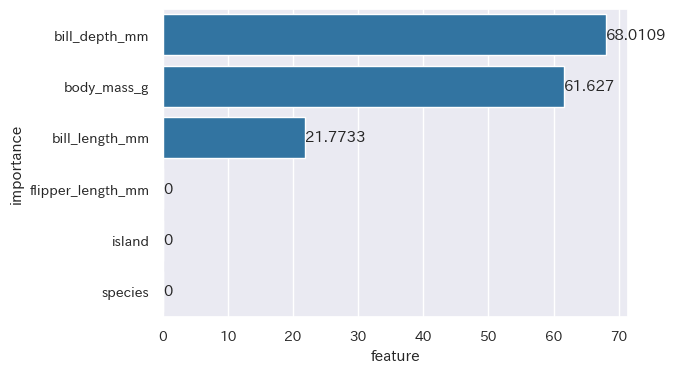

In [101]:
fe_imp = pd.DataFrame(feature_importance_df.groupby(["feature"])["importance"].mean())
fe_imp = fe_imp.sort_values(by="importance", ascending=False)

_ = plt.figure(figsize=(6,4))


p = sns.barplot(x="importance", y=fe_imp.index, data=fe_imp, color='#1f77b4')

plt.ylabel("importance", rotation='vertical')
plt.xlabel("feature")
plt.tick_params(axis='both', which='major')


_ = plt.bar_label(p.containers[0])

## deep learning

# Multi-class classification

## LightGBM

In [81]:
peng = sns.load_dataset("penguins")

peng.dropna(inplace=True)

#Label encoding
from sklearn.preprocessing import LabelEncoder 

label_encoder = LabelEncoder()

cols = ["sex","species", "island"]

for col in cols:
    peng.loc[:, col] = label_encoder.fit_transform(peng.loc[:, col])

peng_y = peng["species"]
peng_X = peng.drop("species", axis=1)


from sklearn.model_selection import train_test_split
train_X, valid_X, train_y, valid_y = train_test_split(peng_X, peng_y, test_size=0.2, random_state=0, stratify=peng_y)


### without fold

### with fold

In [86]:
from sklearn.model_selection import KFold,StratifiedKFold
from statistics import mean

import lightgbm as lgb


params = {
		  'num_leaves': 10,
		  'min_child_samples': 5,
		  'objective': 'multiclass',
# 		  'max_depth': 13,
		  'learning_rate': 0.01,
# 		  "boosting_type": "gbdt",
# 		  "subsample_freq": 3,
# 		  "subsample": 0.9,
# 		  "bagging_seed": 11,
# 		  "metric": 'auc',
# 		  "verbosity": -1,
# 		  'reg_alpha': 0.3,
# 		  'reg_lambda': 0.3,
# 		  'colsample_bytree': 0.9,
		  #'categorical_feature': categories
		 }


folds = StratifiedKFold(n_splits=2)

oof = np.zeros(len(train_X))
# predictions = np.zeros(len(test_X))
feature_importance_df = pd.DataFrame()

print('train_X: ',train_X.shape)
print('train_y: ',train_y.shape)

acc = list()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X,train_y)):
	strLog = "fold {}".format(fold_)
	print(strLog)

	# Output the size of train and validation index
	# print('train_idx: ',len(trn_idx))
	# print('val_idx: ',len(val_idx))

	X_tr, X_val = train_X.iloc[trn_idx], train_X.iloc[val_idx]
	y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

	model = lgb.LGBMClassifier(**params, n_estimators=10, importance_type='gain', n_jobs=-1)

	model.fit(X_tr,
			  y_tr,
			  eval_set=[(X_tr,y_tr),(X_val, y_val)],
			  eval_metric='multi_logloss',
			  verbose=1000,
			  early_stopping_rounds=500)

	oof[val_idx] = model.predict_proba(X_val, num_iteration=model.best_iteration_)[:, 1]

# 	predictions += model.predict_proba(test_X, num_iteration=model.best_iteration_)[:, 1] / folds.n_splits

	acc.append(model.best_score_['valid_1']['multi_logloss'])

	#feature importance
	fold_importance_df = pd.DataFrame()
	fold_importance_df["Feature"] = train_X.columns.values
	fold_importance_df["importance"] = model.feature_importances_[:len(train_X.columns.values)]
	fold_importance_df["fold"] = fold_ + 1
	feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

print(mean(acc))

print('[' + str(len(train_X.columns.values))+']')
print(train_X.columns.values)


train_X:  (266, 6)
train_y:  (266,)
fold 0
Training until validation scores don't improve for 500 rounds
Did not meet early stopping. Best iteration is:
[10]	training's multi_logloss: 0.894101	valid_1's multi_logloss: 0.892838


LGBMClassifier(importance_type='gain', learning_rate=0.01, min_child_samples=5,
               n_estimators=10, num_leaves=10, objective='multiclass')

fold 1
Training until validation scores don't improve for 500 rounds
Did not meet early stopping. Best iteration is:
[10]	training's multi_logloss: 0.884686	valid_1's multi_logloss: 0.903275


LGBMClassifier(importance_type='gain', learning_rate=0.01, min_child_samples=5,
               n_estimators=10, num_leaves=10, objective='multiclass')

0.8980562939318615
[6]
['island' 'bill_length_mm' 'bill_depth_mm' 'flipper_length_mm'
 'body_mass_g' 'sex']


## deep learning

# Regression

In [111]:

mpg = sns.load_dataset("mpg")

mpg.dropna(inplace=True)

total = mpg.isnull().sum().sort_values(ascending=False)
percent = (mpg.isnull().sum()/mpg.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

print(missing_data.head(3))


mpg.drop(["name"], axis=1, inplace=True)

#Label encoding
from sklearn.preprocessing import LabelEncoder 

label_encoder = LabelEncoder()

cols = ["origin"]

for col in cols:
    mpg.loc[:, col] = label_encoder.fit_transform(mpg.loc[:, col])

mpg_y = mpg["weight"]
mpg_X = mpg.drop("weight", axis=1)

from sklearn.model_selection import train_test_split
train_X, valid_X, train_y, valid_y = train_test_split(mpg_X, mpg_y, test_size=0.2, random_state=0)


              Total  Percent
mpg               0      0.0
cylinders         0      0.0
displacement      0      0.0


## Linear Regression

In [112]:
from sklearn.linear_model import LinearRegression


reg = LinearRegression().fit(train_X, train_y)


print("R^2: ", reg.score(train_X, train_y))

# reg.intercept_


# reg.predict(np.array([[3, 5]]))

0.9261665823937103

array([-34.06128769,  33.16087031,   4.32584064,   6.65407136,
        57.15411505,  33.97853508, -62.08759104])

-1318.436484759015

Text(0, 0.5, 'feature')

Text(0.5, 0, 'coefficient')

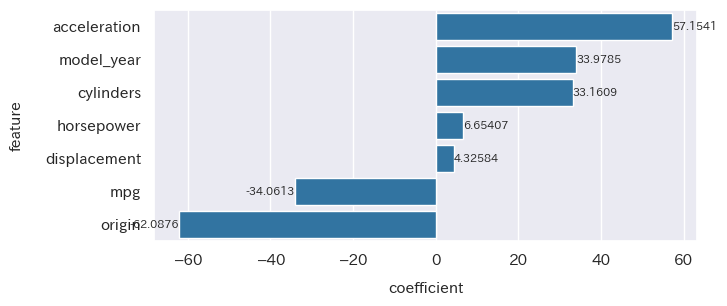

In [125]:
coeff = pd.DataFrame(zip(train_X.columns, reg.coef_), columns=["feature", "coefficient"])
coeff = coeff.sort_values(by="coefficient", ascending=False)

_ = plt.figure(figsize=(7,3))

# Set hue for grouped bar plot
p = sns.barplot(x="coefficient", y="feature", data=coeff, color='#1f77b4')

plt.ylabel("feature", rotation='vertical', labelpad=15, fontsize=11)
plt.xlabel("coefficient", labelpad=10, fontsize=11)
plt.tick_params(axis='both', which='major', labelsize=11)


_ = plt.bar_label(p.containers[0], size=8)


## LightGBM

Doc: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.train.html
Parameters: https://lightgbm.readthedocs.io/en/latest/Parameters.html

Parameter explanaitions:

verbose_eval (bool or int, optional (default=True)) –
Requires at least one validation data. If True, the eval metric on the valid set is printed at each boosting stage. If int, the eval metric on the valid set is printed at every verbose_eval boosting stage.


min_child_samples (int, optional (default=20)) – Minimum number of data needed in a child (leaf).



### Training API

In [40]:
mpg = sns.load_dataset("mpg")

mpg.drop(["name"], axis=1, inplace=True)

#Label encoding
from sklearn.preprocessing import LabelEncoder 

label_encoder = LabelEncoder()

cols = ["origin"]

for col in cols:
    mpg.loc[:, col] = label_encoder.fit_transform(mpg.loc[:, col])

mpg_y = mpg["weight"]
mpg_X = mpg.drop("weight", axis=1)

from sklearn.model_selection import train_test_split
train_X, valid_X, train_y, valid_y = train_test_split(mpg_X, mpg_y, test_size=0.2, random_state=0)



#### without fold

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 318, number of used features: 7
[LightGBM] [Info] Start training from score 2963.393082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's l2: 699632	valid_1's l2: 714747
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's l2: 687351	valid_1's l2: 701555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's l2: 675314	valid_1's l2: 688692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	training's l2: 663517	valid_1's l2: 676032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	training's l2: 651955	valid_

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

Text(0.5, 1.0, 'Feature importance (importance type=gain)')

Text(0, 0.5, 'Features')

Text(0.5, 0, 'Feature importance')

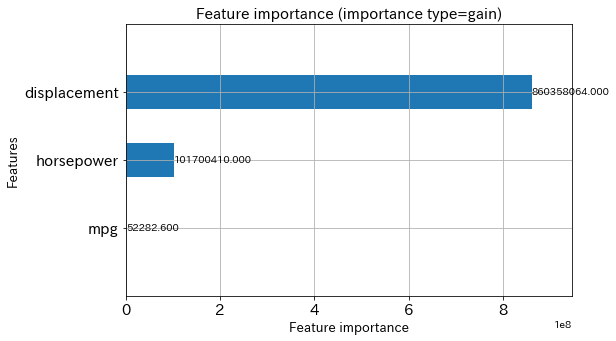

In [43]:
import lightgbm as lgb

from sklearn.metrics import mean_absolute_error, mean_squared_error

params = {
		  'objective': 'regression_l2',
		  'num_leaves': 50,
		  'min_child_samples': 30,
		  # 'objective': 'binary',
# 		  'max_depth': -1,
		  'learning_rate': 0.01,
# 		  "boosting_type": "gbdt",
		  # "subsample_freq": 3,
		  # "subsample": 0.9,
		  # "bagging_seed": 0,
		  "metric": 'l2',
		  # "verbosity": -1,
		  # 'reg_alpha': 0.3,
		  # 'reg_lambda': 0.3,
		  # 'colsample_bytree': 0.9,
		  #'categorical_feature': categories
		 }

lgb_train = lgb.Dataset(train_X, train_y)
lgb_eval = lgb.Dataset(valid_X, valid_y, reference=lgb_train)


model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=1,
    num_boost_round=5,
    early_stopping_rounds=10
)

preds = model.predict(valid_X, num_iteration=model.best_iteration)


print("MAE:  ", mean_absolute_error(preds, valid_y))
print("MSE:  ", mean_squared_error(preds,valid_y))

fig, ax = plt.subplots(1, 1, figsize=(8,5))


lgb.plot_importance(model, max_num_features=30, height=0.5, importance_type="gain", ax=ax)

plt.title("Feature importance (importance type=gain)", size=15)
plt.ylabel("Features", size=13)
plt.xlabel("Feature importance", size=13)

plt.tick_params(axis='both', which='major', labelsize=15)


#### with fold

In [100]:

import lightgbm as lgb

params = {
		  'objective': 'regression_l2',
		  'num_leaves': 50,
		  'min_child_samples': 30,
		  # 'objective': 'binary',
# 		  'max_depth': -1,
		  'learning_rate': 0.01,
# 		  "boosting_type": "gbdt",
		  # "subsample_freq": 3,
		  # "subsample": 0.9,
		  # "bagging_seed": 0,
		  "metric": 'l2',
		  # "verbosity": -1,
		  # 'reg_alpha': 0.3,
		  # 'reg_lambda': 0.3,
		  # 'colsample_bytree': 0.9,
		  #'categorical_feature': categories
		 }


# from sklearn.model_selection import train_test_split
# train_X, valid_X, train_y, valid_y = train_test_split(peng_X, peng_y, test_size=0.2, random_state=0, stratify=peng_y)

lgb_train = lgb.Dataset(mpg_X, mpg_y)
# lgb_eval = lgb.Dataset(valid_X, valid_y, reference=lgb_train)


model = lgb.cv(
    params, lgb_train,
    nfold=2,
    stratified=False,
#     valid_sets=[lgb_train, lgb_eval],
#     verbose_eval=1,
    num_boost_round=1,
#     early_stopping_rounds=10
)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 7
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 199, number of used features: 7
[LightGBM] [Info] Start training from score 2974.391960
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 2966.457286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


### sklearn API

In [105]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_y, valid_y = train_test_split(mpg_X, mpg_y, test_size=0.2, random_state=0)


In [48]:
from sklearn.model_selection import KFold
from statistics import mean

import lightgbm as lgb


params = {
		  'objective': 'regression_l2',
		  'num_leaves': 50,
		  'min_child_samples': 30,
		  # 'objective': 'binary',
# 		  'max_depth': -1,
		  'learning_rate': 0.01,
# 		  "boosting_type": "gbdt",
		  # "subsample_freq": 3,
		  # "subsample": 0.9,
		  # "bagging_seed": 0,
		  "metric": 'l2',
		  # "verbosity": -1,
		  # 'reg_alpha': 0.3,
		  # 'reg_lambda': 0.3,
		  # 'colsample_bytree': 0.9,
		  #'categorical_feature': categories
		 }

folds = KFold(n_splits=2)

oof = np.zeros(len(train_X))
# predictions = np.zeros(len(test_X))
feature_importance_df = pd.DataFrame()

print('train_X: ',train_X.shape)
print('train_y: ',train_y.shape)

acc = list()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X,train_y)):
	strLog = "fold {}".format(fold_)
	print(strLog)

	# Output the size of train and validation index
	# print('train_idx: ',len(trn_idx))
	# print('val_idx: ',len(val_idx))

	X_tr, X_val = train_X.iloc[trn_idx], train_X.iloc[val_idx]
	y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]

	model = lgb.LGBMRegressor(**params, n_estimators=10, importance_type='gain', n_jobs=-1)

	model.fit(X_tr,
			  y_tr,
			  eval_set=[(X_tr,y_tr),(X_val, y_val)],
			  eval_metric='regression_l2',
			  verbose=1,
			  early_stopping_rounds=10)

	oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)

# 	predictions += model.predict_proba(test_X, num_iteration=model.best_iteration_)[:, 1] / folds.n_splits

	acc.append(model.best_score_['valid_1']['l2'])

	#feature importance
	fold_importance_df = pd.DataFrame()
	fold_importance_df["feature"] = train_X.columns.values
	fold_importance_df["importance"] = model.feature_importances_[:len(train_X.columns.values)]
	fold_importance_df["fold"] = fold_ + 1
	feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

print(mean(acc))

print('[' + str(len(train_X.columns.values))+']')
print(train_X.columns.values)


train_X:  (318, 7)
train_y:  (318,)
fold 0
[1]	training's l2: 695231	valid_1's l2: 705461
Training until validation scores don't improve for 10 rounds
[2]	training's l2: 683336	valid_1's l2: 693985
[3]	training's l2: 671679	valid_1's l2: 682742
[4]	training's l2: 660253	valid_1's l2: 671606
[5]	training's l2: 649052	valid_1's l2: 660815
[6]	training's l2: 638074	valid_1's l2: 650129
[7]	training's l2: 627312	valid_1's l2: 639773
[8]	training's l2: 616764	valid_1's l2: 629517
[9]	training's l2: 606424	valid_1's l2: 619579
[10]	training's l2: 596286	valid_1's l2: 609744
Did not meet early stopping. Best iteration is:
[10]	training's l2: 596286	valid_1's l2: 609744


LGBMRegressor(importance_type='gain', learning_rate=0.01, metric='l2',
              min_child_samples=30, n_estimators=10, num_leaves=50,
              objective='regression_l2')

fold 1
[1]	training's l2: 704432	valid_1's l2: 696398
Training until validation scores don't improve for 10 rounds
[2]	training's l2: 692369	valid_1's l2: 685218
[3]	training's l2: 680546	valid_1's l2: 674258
[4]	training's l2: 668959	valid_1's l2: 663513
[5]	training's l2: 657602	valid_1's l2: 652981
[6]	training's l2: 646471	valid_1's l2: 642656
[7]	training's l2: 635561	valid_1's l2: 632535
[8]	training's l2: 624869	valid_1's l2: 622613
[9]	training's l2: 614390	valid_1's l2: 612886
[10]	training's l2: 604119	valid_1's l2: 603351
Did not meet early stopping. Best iteration is:
[10]	training's l2: 604119	valid_1's l2: 603351


LGBMRegressor(importance_type='gain', learning_rate=0.01, metric='l2',
              min_child_samples=30, n_estimators=10, num_leaves=50,
              objective='regression_l2')

606547.7505762312
[7]
['mpg' 'cylinders' 'displacement' 'horsepower' 'acceleration' 'model_year'
 'origin']


In [89]:
import matplotlib

# RC params リセット
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# Set rcParams
params = {"font.family":"IPAexGothic","font.size":10, "figure.figsize":[3,3], "axes.labelsize":11, 
          "xtick.labelsize":10, "ytick.labelsize":10}

# Get nice grid line from seaborn while updating rc params
sns.set_theme(rc=params)
sns.set(font_scale=0.9)
plt.rcParams["font.family"] = "IPAexGothic"


Text(0, 0.5, 'importance')

Text(0.5, 0, 'feature')

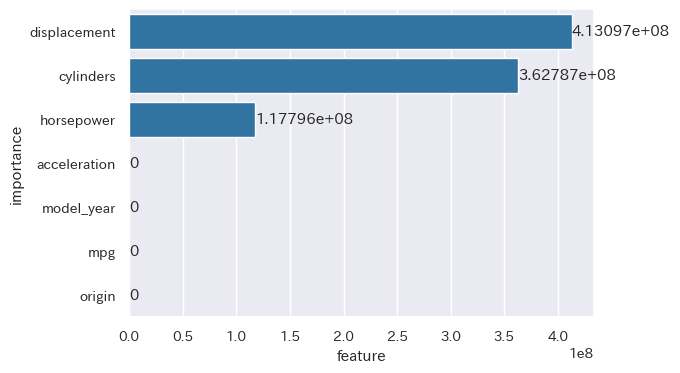

In [94]:
fe_imp = pd.DataFrame(feature_importance_df.groupby(["feature"])["importance"].mean())
fe_imp = fe_imp.sort_values(by="importance", ascending=False)

_ = plt.figure(figsize=(6,4))


p = sns.barplot(x="importance", y=fe_imp.index, data=fe_imp, color='#1f77b4')

plt.ylabel("importance", rotation='vertical')
plt.xlabel("feature")
plt.tick_params(axis='both', which='major')


_ = plt.bar_label(p.containers[0])